# Case 2 (2) Long-Short Portfolio strategy by chasing ups and downs

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.pyplot import MultipleLocator
import statsmodels.formula.api as sm

## 导入数据与数据预处理

In [2]:
df = pd.read_csv(r'D:\Code Library\FIN3080\Project 2\case 2 part 1\个股月度回报率\TRD_Mnth.csv')
df

,Stkcd,Trdmnt,Msmvttl,Mretwd
0,1,2006-01,12355970.65,0.034202
1,1,2006-02,13309423.50,0.077165
2,1,2006-03,12394887.09,-0.068713
3,1,2006-04,15333078.53,0.237049
4,1,2006-05,17084318.47,0.114213
...,...,...,...,...
392030,605599,2021-11,9636666.94,0.061697
392031,605599,2021-12,10468889.19,0.086360
392032,605599,2022-01,9247778.04,-0.116642
392033,605599,2022-02,10227778.07,0.105971


In [3]:
df['Trdmnt'] = pd.to_datetime(df['Trdmnt']).dt.to_period('M') # 生成datetime时间戳
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392035 entries, 0 to 392034
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype    
---  ------   --------------   -----    
 0   Stkcd    392035 non-null  int64    
 1   Trdmnt   392035 non-null  period[M]
 2   Msmvttl  392035 non-null  float64  
 3   Mretwd   390193 non-null  float64  
dtypes: float64(2), int64(1), period[M](1)
memory usage: 12.0 MB


In [4]:
stock_id = df.loc[df.Trdmnt == '2007-01','Stkcd'] # 选取2007-01及之前已上市的股票
df1 = df.loc[df.Stkcd.isin(stock_id)]
df1 = df1[df1.Trdmnt >= '2007-01']
df1 = df1.sort_values(['Stkcd','Trdmnt'])
df1 = df1.dropna().reset_index(drop = True)
df1

,Stkcd,Trdmnt,Msmvttl,Mretwd
0,1,2007-01,37223577.71,0.322046
1,1,2007-02,37067911.94,-0.004182
2,1,2007-03,36737122.17,-0.008924
3,1,2007-04,50494084.77,0.374470
4,1,2007-05,55825637.45,0.105588
...,...,...,...,...
217508,601991,2021-11,31362105.44,-0.069853
217509,601991,2021-12,40163328.70,0.280632
217510,601991,2022-01,32725675.24,-0.185185
217511,601991,2022-02,35204893.06,0.075758


## 根据前一个月个股回报率大小进行分组

In [5]:
df1['prev_ret'] = df1.groupby('Stkcd').Mretwd.shift(1) # 前一个月回报率数据向下移动一格，便于分组使用
df1 = df1.dropna().reset_index(drop = True) # 去除2007年1月的空数据格
perc = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # 生成百分位数，以此分组
df1['allo'] = 1 # 生成新列供存储数据
df1

,Stkcd,Trdmnt,Msmvttl,Mretwd,prev_ret,allo
0,1,2007-02,37067911.94,-0.004182,0.322046,1
1,1,2007-03,36737122.17,-0.008924,-0.004182,1
2,1,2007-04,50494084.77,0.374470,-0.008924,1
3,1,2007-05,55825637.45,0.105588,0.374470,1
4,1,2007-06,57427589.65,0.055417,0.105588,1
...,...,...,...,...,...,...
216258,601991,2021-11,31362105.44,-0.069853,-0.242340,1
216259,601991,2021-12,40163328.70,0.280632,-0.069853,1
216260,601991,2022-01,32725675.24,-0.185185,0.280632,1
216261,601991,2022-02,35204893.06,0.075758,-0.185185,1


In [6]:
def allocate_ret(df): # 构造函数，使得每个公司按照前一个月回报率进行区间排名（排名分0-9，0代表上月回报率最小的公司）
    quan = df['prev_ret'].describe(percentiles = perc)
    quan = quan.iloc[4:13]
    df.loc[df.prev_ret <= quan[0],'allo'] = 0
    df.loc[(df.prev_ret > quan[0])&(df.prev_ret <= quan[1]),'allo'] = 1
    df.loc[(df.prev_ret > quan[1])&(df.prev_ret <= quan[2]),'allo'] = 2
    df.loc[(df.prev_ret > quan[2])&(df.prev_ret <= quan[3]),'allo'] = 3
    df.loc[(df.prev_ret > quan[3])&(df.prev_ret <= quan[4]),'allo'] = 4
    df.loc[(df.prev_ret > quan[4])&(df.prev_ret <= quan[5]),'allo'] = 5
    df.loc[(df.prev_ret > quan[5])&(df.prev_ret <= quan[6]),'allo'] = 6
    df.loc[(df.prev_ret > quan[6])&(df.prev_ret <= quan[7]),'allo'] = 7
    df.loc[(df.prev_ret > quan[7])&(df.prev_ret <= quan[8]),'allo'] = 8
    df.loc[df.prev_ret > quan[8],'allo'] = 9
    return df

In [7]:
df1 = df1.groupby('Trdmnt').apply(allocate_ret) # 按时间分组进行排名
df1

,Stkcd,Trdmnt,Msmvttl,Mretwd,prev_ret,allo
0,1,2007-02,37067911.94,-0.004182,0.322046,7
1,1,2007-03,36737122.17,-0.008924,-0.004182,0
2,1,2007-04,50494084.77,0.374470,-0.008924,0
3,1,2007-05,55825637.45,0.105588,0.374470,6
4,1,2007-06,57427589.65,0.055417,0.105588,6
...,...,...,...,...,...,...
216258,601991,2021-11,31362105.44,-0.069853,-0.242340,0
216259,601991,2021-12,40163328.70,0.280632,-0.069853,1
216260,601991,2022-01,32725675.24,-0.185185,0.280632,9
216261,601991,2022-02,35204893.06,0.075758,-0.185185,1


In [8]:
ew_pf = df1.groupby(['allo','Trdmnt']).agg({'Mretwd':'mean'}).reset_index() # 平均取每个投资组合当月的收益率
ew_pf = ew_pf.rename(columns = {'Trdmnt':'ym'})
ew_pf

,allo,ym,Mretwd
0,0,2007-02,0.160109
1,0,2007-03,0.100590
2,0,2007-04,0.252663
3,0,2007-05,0.139803
4,0,2007-06,-0.171314
...,...,...,...
1815,9,2021-11,0.037562
1816,9,2021-12,0.038997
1817,9,2022-01,-0.127164
1818,9,2022-02,0.041044


In [9]:
result = ew_pf.groupby('allo').agg({'Mretwd':'mean'}).reset_index()
result

,allo,Mretwd
0,0,0.018218
1,1,0.019411
2,2,0.019277
3,3,0.019688
4,4,0.018529
5,5,0.019516
6,6,0.016918
7,7,0.013389
8,8,0.009197
9,9,0.001064


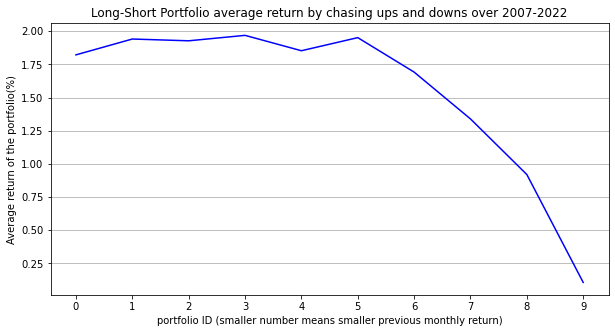

In [10]:
plt.figure(1, figsize = [10,5])
plt.plot(result.allo, result.Mretwd*100,'b')
plt.xlabel('portfolio ID (smaller number means smaller previous monthly return)')
plt.ylabel('Average return of the portfolio(%)')
plt.title('Long-Short Portfolio average return by chasing ups and downs over 2007-2022')
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.grid(axis = 'y')
plt.show()

## 追涨杀跌策略
结论：上个月回报率低的股票下个月回报率普遍较高，但是上个月回报率高的股票下个月回报率较低

适用条件：
* 1. 不买ST股票，因其波动性过大，可能退市（在本题数据源中已经剔除）
* 2. 等权买入股票构建投资组合

## CAPM模型以及多空投资组合构建

### 本题所用市场收益率为中证800指数，无风险利率为Shibor利率（换算成月利率）

In [11]:
reg = pd.read_csv(r'D:\Code Library\FIN3080\Project 2\case 2 part 1\capm_reg.csv') # 数据预处理
reg = reg.rename(columns = {'Month':'ym'})
reg = reg[reg.ym >= '2007-02'].reset_index(drop = True) # 去除2007年1月的空数据
reg['ym'] = pd.to_datetime(reg.ym).dt.to_period('M')
reg

,ym,rm,rf
0,2007-02,0.091203,0.001888
1,2007-03,0.110805,0.001292
2,2007-04,0.293472,0.001974
3,2007-05,0.101181,0.001517
4,2007-06,-0.072070,0.001689
...,...,...,...
177,2021-11,-0.003992,0.001621
178,2021-12,0.020264,0.001577
179,2022-01,-0.083353,0.001568
180,2022-02,0.012716,0.001661


In [12]:
capm = pd.merge(reg, ew_pf, how = 'outer', on = 'ym') #与等权投资组合数据合并
capm

,ym,rm,rf,allo,Mretwd
0,2007-02,0.091203,0.001888,0,0.160109
1,2007-02,0.091203,0.001888,1,0.205453
2,2007-02,0.091203,0.001888,2,0.202917
3,2007-02,0.091203,0.001888,3,0.202048
4,2007-02,0.091203,0.001888,4,0.227684
...,...,...,...,...,...
1815,2022-03,-0.078057,0.001627,5,0.033310
1816,2022-03,-0.078057,0.001627,6,-0.022765
1817,2022-03,-0.078057,0.001627,7,-0.036124
1818,2022-03,-0.078057,0.001627,8,-0.026362


In [13]:
capm = capm.sort_values(['ym','allo'])
capm = capm[(capm.allo == 3) | (capm.allo == 9)].reset_index(drop = True) # 选取最高回报率组合与最低回报率组合
capm

,ym,rm,rf,allo,Mretwd
0,2007-02,0.091203,0.001888,3,0.202048
1,2007-02,0.091203,0.001888,9,0.153718
2,2007-03,0.110805,0.001292,3,0.194394
3,2007-03,0.110805,0.001292,9,0.216259
4,2007-04,0.293472,0.001974,3,0.356420
...,...,...,...,...,...
359,2022-01,-0.083353,0.001568,9,-0.127164
360,2022-02,0.012716,0.001661,3,0.056106
361,2022-02,0.012716,0.001661,9,0.041044
362,2022-03,-0.078057,0.001627,3,0.001301


In [14]:
capm['sft_ret'] = capm.Mretwd.shift(1) # 将最低回报率组合的回报率向下移动一格
capm['ls_ret'] = capm['sft_ret'] - capm['Mretwd'] # 高回报率组合回报率减去低回报率组合回报率
capm = capm.groupby('ym').agg({'ls_ret':'last','rm':'last','rf':'last'}).reset_index() # 多空投资组合的净收益率取每个时间段第二个值
capm

,ym,ls_ret,rm,rf
0,2007-02,0.048330,0.091203,0.001888
1,2007-03,-0.021865,0.110805,0.001292
2,2007-04,0.022373,0.293472,0.001974
3,2007-05,0.066210,0.101181,0.001517
4,2007-06,0.003293,-0.072070,0.001689
...,...,...,...,...
177,2021-11,0.019838,-0.003992,0.001621
178,2021-12,0.044538,0.020264,0.001577
179,2022-01,0.067818,-0.083353,0.001568
180,2022-02,0.015062,0.012716,0.001661


In [15]:
capm['y'] = capm.ls_ret - capm.rf # 生成回归因变量
capm['x'] = capm.rm - capm.rf  # 生成回归自变量
capm = capm[['ym','y','x']]
capm

,ym,y,x
0,2007-02,0.046441,0.089315
1,2007-03,-0.023157,0.109513
2,2007-04,0.020400,0.291498
3,2007-05,0.064693,0.099664
4,2007-06,0.001604,-0.073759
...,...,...,...
177,2021-11,0.018216,-0.005613
178,2021-12,0.042961,0.018687
179,2022-01,0.066250,-0.084921
180,2022-02,0.013401,0.011055


### 多空投资组合CAPM模型alpha预测结果

In [16]:
ls_pf = sm.ols(formula = 'y~x', data = capm).fit() # 回归分析及结果
ls_pf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1501
Date:                Wed, 20 Apr 2022   Prob (F-statistic):              0.699
Time:                        21:15:28   Log-Likelihood:                 320.29
No. Observations:                 182   AIC:                            -636.6
Df Residuals:                     180   BIC:                            -630.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0168      0.003      5.401      0.000       0.011       0.023
x             -0.0145      0.038     -0.387      0.699      -0.089       0.059
==============================================================================
Omnibus:                       11.129   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               21.616
Skew:                          -0.231   Prob(JB):                     2.02e-05
Kurtosis:                       4.624   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""